In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = os.path.join('/content/drive/My Drive/Deep Learning/SrUnfolding')
!pip install tensorlayer

Mounted at /content/drive
     |████████████████████████████████| 368kB 5.7MB/s 
     |████████████████████████████████| 3.3MB 24.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/HR
[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/LR


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/HR
[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/LR
 1/12 [=>............................] - ETA: 12:52 - loss: 0.7486 - accuracy: 0.3761[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/HR
[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/LR
 2/12 [====>.........................] - ETA: 10:41 - loss: 0.7007 - accuracy: 0.3711[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/HR
[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/LR
 3/12 [======>.......................] - ETA: 9:35 - loss: 0.6614 - accuracy: 0.3643 [TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/HR
[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/LR
 4/12 [=========>....................] - ETA: 8:30 - loss: 0.6345 - accuracy: 0.3568[TL] read 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


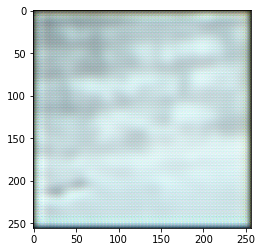

In [13]:
import math
import pickle
import random
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Layer, Conv2D, LeakyReLU, GlobalAveragePooling2D, Activation, Lambda
from tensorflow.keras.activations import sigmoid
from tensorflow.keras import Model
import numpy as np
import tensorlayer as tl
import os
import matplotlib.pyplot as plt

batch_size = 16
class CALayer(Layer):
    def __init__(self, nf, reduction=16):
        super(CALayer, self).__init__()
        self.body = Sequential([
            Conv2D(nf // reduction, kernel_size=(1, 1), strides=(1, 1)),
            LeakyReLU(alpha=0.2),
            Conv2D(nf, kernel_size=(1, 1), strides=(1, 1)),
            Activation('sigmoid')
        ])
        self.avg = GlobalAveragePooling2D()
        self.nf = nf

    def call(self, x):
        y = tf.reshape(self.avg(x), [batch_size, 1, 1, self.nf])
        y = self.body(y)
        #y = tf.reshape(self.body(y), [64, 1, 1, self.nf])
        mult = tf.multiply(x, y)
        return mult


class CRBLayer(Layer):
    def __init__(self, nf1, nf2):
        super(CRBLayer, self).__init__()
        self.body = Sequential([
            Conv2D(nf1 + nf2, kernel_size=(3, 3), strides=(1, 1), padding="same"),
            LeakyReLU(0.2),
            Conv2D(nf1, kernel_size=(3, 3), strides=(1, 1), padding="same"),
            CALayer(nf1),
        ])

    def call(self, x):
        f1, f2 = x
        body = self.body(tf.concat(x, -1))
        f1 = tf.math.add(body, f1)
        return f1


class Estimator(Layer):
    def __init__(self, num_blocks=5):
        super(Estimator, self).__init__()

        self.head_LR = Conv2D(32, kernel_size=(1, 1), strides=(1, 1), padding="valid")
        self.head_HR = Conv2D(32, kernel_size=(9, 9), strides=(4, 4), padding="same")
        self.body = self.body = CRBLayer(32, 32)
        self.out = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="same")
        self.globalPooling = GlobalAveragePooling2D()

    def call(self, GT, LR):
        lrf = self.head_LR(LR)
        hrf = self.head_HR(GT)

        f = [lrf, hrf]
        f = self.body(f)
        f = [f, hrf]
        f = self.body(f)
        f = [f, hrf]
        f = self.body(f)
        f = [f, hrf]
        f = self.body(f)
        #f = [f, hrf]
        #f = self.body(f)
        f = self.out(f)
        a = self.globalPooling(f)
        return a


class Restorer(Layer):
    def __init__(self, nb=8, scale=4, input_para=10, min=0.0, max=1.0):
        super(Restorer, self).__init__()
        self.min = min
        self.max = max
        self.para = input_para
        self.num_blocks = nb

        self.head = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same")
        self.body = CRBLayer(64, 10)
        self.fusion = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same")

        if scale == 4:  # x4
            Subpixel_layer = Lambda(lambda x: tf.nn.depth_to_space(x, scale // 2))
            self.upscale = Sequential()
            self.upscale.add(Conv2D(256, kernel_size=3, strides=(1, 1), padding="same", use_bias=True))
            self.upscale.add(Lambda(lambda x: tf.nn.depth_to_space(x, scale // 2)))
            self.upscale.add(Conv2D(256, kernel_size=3, strides=(1, 1), padding="same", use_bias=True))
            self.upscale.add(Lambda(lambda x: tf.nn.depth_to_space(x, scale // 2)))
            self.upscale.add(Conv2D(3, kernel_size=3, strides=(1, 1), padding="same", use_bias=True))
        else:  # x2, x3
            Subpixel_layer = Lambda(lambda x: tf.nn.depth_to_space(x, scale))
            self.upscale = Sequential()
            self.upscale.add(Conv2D(64, kernel_size=3, strides=(1, 1), padding="same", use_bias=True))
            self.upscale.add(Lambda(lambda x: tf.nn.depth_to_space(x, scale)))
            self.upscale.add(Conv2D(64, kernel_size=3, strides=(1, 1), padding="same"))

    def call(self, input, ker_code):
        B, H, W, C = input.shape  # I_LR batch
        B_h, C_h = ker_code.shape  # Batch, Len=10
        ker_code_exp = tf.reshape(tf.repeat(ker_code, repeats=H*W, axis=0), [B_h, H, W, C_h])

        f = self.head(input)
        inputs = [f, ker_code_exp]
        f = self.body(inputs)
        inputs = [f, ker_code_exp]
        f = self.body(inputs)
        inputs = [f, ker_code_exp]
        f = self.body(inputs)
        inputs = [f, ker_code_exp]
        f = self.body(inputs)
        inputs = [f, ker_code_exp]
        f = self.body(inputs)
        #inputs = [f, ker_code_exp]
        #f = self.body(inputs)
        #inputs = [f, ker_code_exp]
        #f = self.body(inputs)
        #inputs = [f, ker_code_exp]
        #f = self.body(inputs)
        f = self.fusion(f)
        out = self.upscale(f)
        return out


class DAN(Layer):
    def __init__(
            self,
            nb=16,
            upscale=4,
            input_para=10,
            kernel_size=21,
            loop=8,
            pca_matrix_path=None,
    ):
        super(DAN, self).__init__()

        self.ksize = kernel_size
        self.loop = loop
        self.scale = upscale

        self.Restorer = Restorer(nb=nb, scale=self.scale, input_para=input_para)
        self.Estimator = Estimator()

        with open(pca_matrix_path, 'rb') as file:
            self.encoder = tf.Variable(pickle.load(file), trainable=False)
            self.encoder = tf.dtypes.cast(self.encoder, tf.float64)
        kernel = np.zeros([1, self.ksize, self.ksize])
        kernel[:, self.ksize // 2, self.ksize // 2] = 1
        self.init_kernel = tf.Variable(kernel, trainable=False)
        self.init_ker_map = tf.Variable(
            tf.matmul(tf.reshape(self.init_kernel, [1, 1, self.ksize ** 2]), self.encoder)[:, 0],
            trainable=False
        )

    def call(self, lr):
        #srs = []
        #ker_maps = []

        B, C, H, W = lr.shape
        ker_map = tf.repeat(self.init_ker_map, B, 0)

        for i in range(self.loop):
            sr = self.Restorer(lr, ker_map)
            ker_map = self.Estimator(sr, lr)

            #srs.append(sr)
            #ker_maps.append(ker_map)
        return sr


class DataReader(object):
    IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']
    GT_size = 256

    def __init__(self, hr_path, lr_path):
        self.hr_path = hr_path
        self.lr_path = lr_path
        self.batch_size = batch_size
        self.img_name_list, self.img_list = self.get_image_paths(hr_path)
        self.train_size = int(math.ceil(len(self.img_list) / self.batch_size))

    def is_image_file(self, filename):
        return any(filename.endswith(extension) for extension in self.IMG_EXTENSIONS)

    def get_image_paths(self, path):
        assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
        images = []
        images_name = []
        for dirpath, _, fnames in sorted(os.walk(path)):
            for fname in sorted(fnames):
                if self.is_image_file(fname):
                    img_path = os.path.join(dirpath, fname)
                    images.append(img_path)
                    images_name.append(fname)
        assert images, '{:s} has no valid image file'.format(path)
        return sorted(images_name), sorted(images)

    def default_collate(self, batch):
        r"""Puts each data field into a tensor with outer dimension batch size"""
        elem = batch[0]
        #a = {key: self.default_collate([d[key] for d in batch]) for key in elem}
        return tf.stack(batch, 0)


    def augment(self, img, hflip=True, rot=True):
        # horizontal flip OR rotate
        hflip = hflip and random.random() < 0.5
        vflip = rot and random.random() < 0.5
        rot90 = rot and random.random() < 0.5

        def _augment(img):
            if hflip:
                img = img[:, ::-1, :]
            if vflip:
                img = img[::-1, :, :]
            if rot90:
                img = img.transpose(1, 0, 2)
            return img
        return _augment(img)

    def test_image(self):
        lr_batch = []
        train_lr_imgs = tl.vis.read_images(self.img_name_list[:16], path=self.lr_path, n_threads=32, 
                                           printable=True)
        train_lr_imgs = [(img * 255).round() / 255 for img in train_lr_imgs]
        for img in train_lr_imgs:
            lr_batch.append(img)
        lr_tensor = self.default_collate(lr_batch)                
        return lr_tensor

    def next_batch(self):
        while True:
            train_hr_imgs = tl.vis.read_images(self.img_name_list[:self.batch_size], path=self.hr_path, n_threads=32,
                                               printable=True)
            train_lr_imgs = tl.vis.read_images(self.img_name_list[:self.batch_size], path=self.lr_path, n_threads=32,
                                               printable=True)
            train_hr_imgs = [(img * 255).round() / 255 for img in train_hr_imgs]
            train_lr_imgs = [(img * 255).round() / 255 for img in train_lr_imgs]
            hr_batch = []
            lr_batch = []
            for img in train_hr_imgs:
                '''
                H, W, C = img.shape
                rnd_h = random.randint(0, max(0, H - self.GT_size))
                rnd_w = random.randint(0, max(0, W - self.GT_size))
                img_GT = img[rnd_h : rnd_h + self.GT_size, rnd_w : rnd_w + self.GT_size, :]

                # augmentation - flip, rotate
                img_GT = self.augment(img_GT)
                img_GT = img_GT[:, :, [2, 1, 0]]
                img_GT = tf.convert_to_tensor(np.ascontiguousarray(img_GT), dtype=tf.float64)
                '''
                hr_batch.append(img)
            for img in train_lr_imgs:
                lr_batch.append(img)
            hr_tensor = self.default_collate(hr_batch)
            lr_tensor = self.default_collate(lr_batch)
            yield lr_tensor, hr_tensor


model = Sequential()
dataset = DataReader(path + '/SrImages/HR', path + '/SrImages/LR')
def main():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    epochs = 3
    model.add(DAN(nb=40, input_para=10, loop=4, upscale=4, kernel_size=21,
                  pca_matrix_path=path + '/pca_matrix_keras.pth'))
    mae = tf.keras.losses.MeanAbsoluteError()
    model.compile(loss=mae, optimizer='adam', metrics=['accuracy'])
    model.fit_generator(dataset.next_batch(), dataset.train_size, epochs)
    model.summary()
    lr_test = dataset.test_image()
    hr_image = model(lr_test)
    for i in range(10):
      plt.imshow(tf.squeeze(lr_test[i]))
      plt.imshow(tf.squeeze(hr_image[i]))


if __name__ == '__main__':
    main()

[TL] read 16 from /content/drive/My Drive/Deep Learning/SrUnfolding/SrImages/LR


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


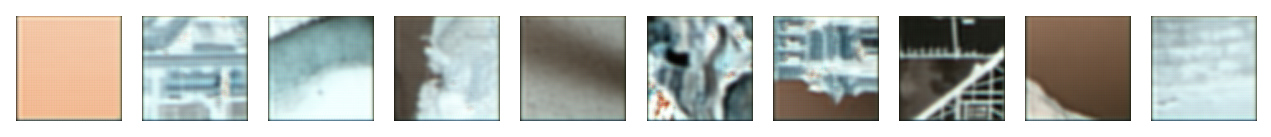

In [26]:
    lr_test = dataset.test_image()
    hr_image = model(lr_test)
    plt.figure(20, figsize=(10, 10), dpi=160)

    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(tf.squeeze(hr_image[i]))
        plt.axis("off")